In [2]:
import torch
from torch.autograd import Variable
from torch import nn, optim
import numpy as np
import matplotlib as mpt
from matplotlib import pyplot as plt
from matplotlib import image as matImg
import os 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as trf
import matplotlib.gridspec as gridspec
%matplotlib inline

### 准备数据

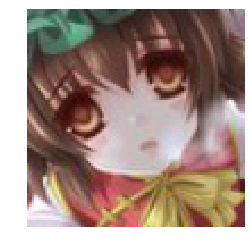

In [3]:
### 读取文件夹下所有文件
from matplotlib import image as matImg 
x = "./faces/0000fdee4208b8b7e12074c920bc6166-0.jpg"
def read_img(path):
    return matImg.imread(path)
plt.axis("off")
x = read_img(x) # 96*96*3
x = trf.ToTensor()(x) # 3*96*96 且归一化
x = x.permute(-2,-1,-3)
x = x.numpy()
x.shape
# x = x.permute(96,96,3)
# x = x.numpy() # 3*96*96
plt.imshow(x)

In [4]:
# 获取图片的路径
def get_img_path(path):
    ls = os.listdir(path)
    ls = [path+"/"+x for x in ls]
    return ls

In [6]:
# 读取所有图片
import os
from matplotlib import image as matImg
path = "./faces"
def load_data(path):
    img_path = get_img_path(path) # 将文件夹下所有图片的路径存入list中
    return [read_img(x) for x in img_path] # 通过路径读取每个图片，以np.array存入list
#     print((img_path[0]))
data = load_data(path)

In [7]:
type(data)

list

###  生成训练数据迭代器

In [10]:
class dataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        img = self.data[index]
        if self.transform is not None:
            img = self.transform(img)
        return img
transforms = trf.Compose([
    trf.ToTensor(),
    trf.Normalize([0.5]*3, [0.5]*3)
])
dset = dataset(data, transforms)
dload = DataLoader(dset, shuffle=True, batch_size=model_param.batch_size)
dload.__iter__().__next__().shape

torch.Size([128, 3, 96, 96])

### 模型超参数

In [9]:
class Param:
    def __init__(self):
        ## 数据处理
        self.path = "./faces"
        self.batch_size = 128
        self.img_size = 96
        ## 随机噪声数据生成
        self.noise = 128
        ## 生成器
        self.G_feature_map = 64
        ## 判别器
        self.D_feature_map = 64    
        self.leak_k = 0.2
        ## 优化
        self.learning_rate = 2e-4
        self.betas=(0.5, 0.999)
        ## 模型训练
        self.epochs = 50000
        ## 画图
        self.interval = 50
        self.deta_inv = 2
model_param = Param()

### 生成器 ：根据随机噪声输入 得到对应输出数据

In [11]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.nz = model_param.noise
        self.fm = model_param.G_feature_map
        self.out = nn.Sequential(
            # 100*1*1 --> (64*8)*4*4
            # ConvTranspose2d 是二维转置卷积
            nn.ConvTranspose2d(self.nz, self.fm * 8, kernel_size=4, bias=False), 
            nn.BatchNorm2d(self.fm * 8), # 批规范化  #如果不好加上0.5试试
            nn.ReLU(True), # True为直接修改覆盖 ，节省内存
 
            # (64*8)*4*4 --> (64*4)*8*8
            nn.ConvTranspose2d(self.fm * 8, self.fm * 4, kernel_size=4, stride=2, padding=1, bias=False),  
            nn.BatchNorm2d(self.fm * 4),
            nn.ReLU(True),
 
            # (64*4)*8*8 --> (64*2)*16*16
            nn.ConvTranspose2d(self.fm * 4, self.fm * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(self.fm * 2),
            nn.ReLU(True),
 
            # (64*2)*16*16 --> 64*32*32
            nn.ConvTranspose2d(self.fm * 2, self.fm, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(self.fm),
            nn.ReLU(True),
 
            # 64*32*32 --> 3*96*96
            nn.ConvTranspose2d(self.fm, 3, kernel_size=5, stride=3, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.out(x)
        return x
G = Generator().cuda()

### 判别器: 输出输入数据的判别分数

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fm = model_param.D_feature_map
        self.k = model_param.leak_k
        self.out = nn.Sequential(
            # 3*96*96 --> 64*32*32
            nn.Conv2d(3, self.fm, kernel_size=5, stride=3, padding=1, bias=False),
            nn.LeakyReLU(self.k,True),
 
            # 64*32*32 --> (64*2)*16*16
            nn.Conv2d(self.fm, self.fm * 2, kernel_size=4, stride=2, padding=1, bias=False), 
            nn.BatchNorm2d(self.fm * 2),
            nn.LeakyReLU(self.k,True),
 
            # (64*2)*16*16 --> (64*4)*8*8
            nn.Conv2d(self.fm * 2, self.fm * 4, kernel_size=4, stride=2,padding=1, bias=False), 
            nn.BatchNorm2d(self.fm * 4),
            nn.LeakyReLU(self.k,True),
            # (64*4)*8*8 --> (64*8)*4*4
            nn.Conv2d(self.fm * 4, self.fm * 8, kernel_size=4, stride=2,padding=1, bias=False),
            nn.BatchNorm2d(self.fm * 8),
            nn.LeakyReLU(self.k,True),
 
            # (64*8)*4*4 --> 1 * 1 * 1
            nn.Conv2d(self.fm * 8, 1, kernel_size=4, bias=False), 
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.out(x).view(-1)
D = Discriminator().cuda()

### 判别器损失值计算
D（x）为判别器的输出值， 同时将生成器数据和真实数据做判断    
Max-> Loss = ∑x～Pdata(x){㏒D(x)} + ∑x～Pg(x){㏒(1-D(x))}


In [13]:
def Discrim_Loss(real_score, fake_score):
    loss = 0.5*((real_score - 1) ** 2).mean() + 0.5*( fake_score ** 2).mean()
    return loss

### 生成器损失值计算

1. Loss的计算同上，Min -> Loss，目标策略是最小化Loss
2. 但是训练生成器的时候，并不改变判别器的参数，也就是说Loss表达式中的第一项的值并不会随着G的优化而改变 所以：

    Min -> Loss = ∑x～Pg(x){㏒(1-D(x))}

In [14]:
def Gen_Loss(fake_score):
    loss = 0.5*((fake_score - 1) ** 2).mean()
    return loss

### 模型优化算法
1. real_img 和 fake_image 通过判别器后分别得到各自的D（x）
2. 再通过损失值函数算出Loss ,通过Loss去优化模型


In [15]:
G_optim = optim.Adam(G.parameters(), lr=model_param.learning_rate, betas=model_param.betas)

In [16]:
D_optim = optim.Adam(G.parameters(), lr=model_param.learning_rate, betas=model_param.betas)

### 模型的训练

tensor([[ 0.5030,  0.1890, -0.6361,  ...,  0.3948,  0.9394, -0.0446],
        [ 0.6025, -0.8316, -0.6392,  ...,  0.7563,  0.5887, -0.1331],
        [-0.8373, -0.7303,  0.3257,  ..., -0.4351, -0.2256,  0.4298],
        ...,
        [ 0.2532, -0.6395, -0.3648,  ..., -0.1642, -0.5506, -0.1124],
        [ 0.4259, -0.3795,  0.9959,  ...,  0.4614, -0.7288, -0.0901],
        [ 0.9234, -0.2888, -0.3183,  ...,  0.9609, -0.9703,  0.8510]])


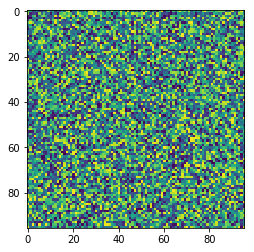

In [17]:
y = (torch.rand(96, 96) - 0.5) / 0.5
plt.imshow(y.numpy())
print(y)


### 画图

In [18]:
# plt.rcParams['figure.figsize'] = (, 10.0) # 设置画图的尺寸
# plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'

def show_images(images): # 定义画图工具 16*3*96*96
    sqrtn = 4
    sqrtimg = 96

    fig = plt.figure(figsize=(sqrtn*4, sqrtn*4))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        # 3*96*96 tensor
        img = img.permute(-2,-1,-3).numpy()
        # 96*96*3 narray
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img)
    return None

### 训练

the times of 0 batch trainning :G loss is 0.32234621047973633, D loss is 0.23039251565933228


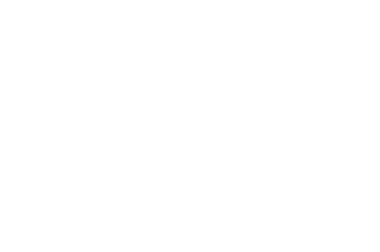

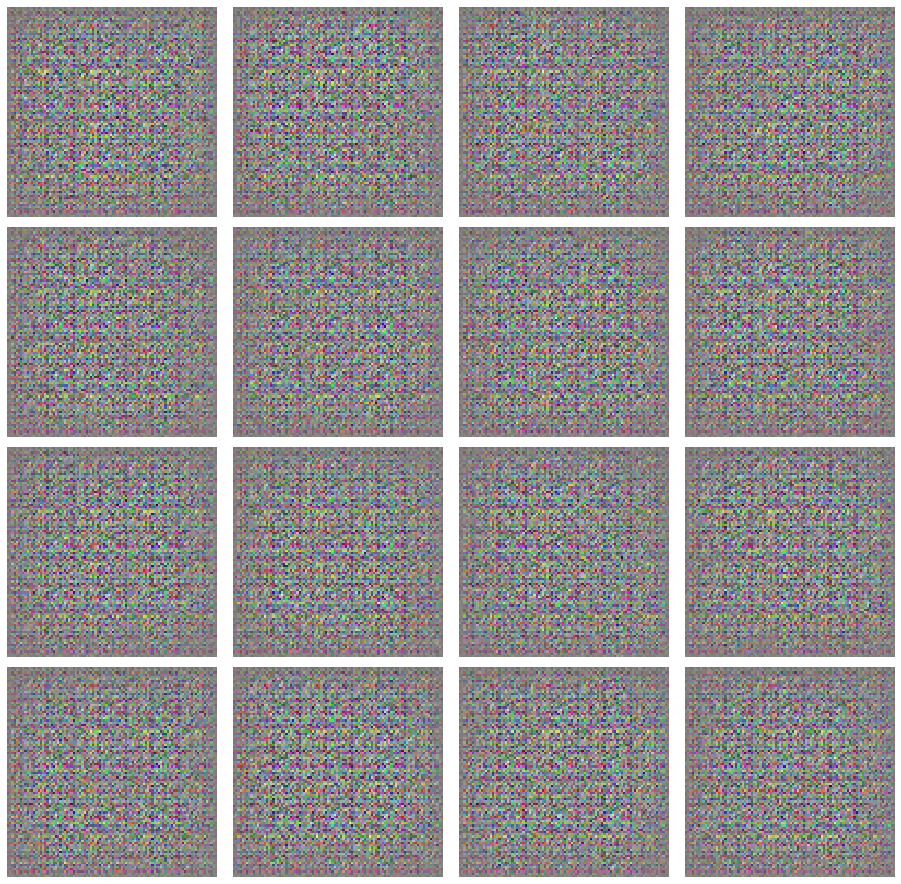

the times of 1 batch trainning :G loss is 0.3100500702857971, D loss is 0.2218724638223648
the times of 2 batch trainning :G loss is 0.2965341806411743, D loss is 0.21568165719509125
the times of 3 batch trainning :G loss is 0.2812756299972534, D loss is 0.21775683760643005
the times of 4 batch trainning :G loss is 0.268457293510437, D loss is 0.2133970856666565
the times of 5 batch trainning :G loss is 0.25896531343460083, D loss is 0.2150435596704483
the times of 6 batch trainning :G loss is 0.24710756540298462, D loss is 0.2183731347322464
the times of 7 batch trainning :G loss is 0.24020668864250183, D loss is 0.2169501781463623
the times of 8 batch trainning :G loss is 0.23076492547988892, D loss is 0.2194342017173767
the times of 9 batch trainning :G loss is 0.2245052009820938, D loss is 0.22126737236976624
the times of 10 batch trainning :G loss is 0.21952217817306519, D loss is 0.22110988199710846
the times of 11 batch trainning :G loss is 0.21187451481819153, D loss is 0.22405

the times of 88 batch trainning :G loss is 0.15833896398544312, D loss is 0.23097681999206543
the times of 89 batch trainning :G loss is 0.1588158905506134, D loss is 0.22644934058189392
the times of 90 batch trainning :G loss is 0.15821531414985657, D loss is 0.234782874584198
the times of 91 batch trainning :G loss is 0.15817366540431976, D loss is 0.22804537415504456
the times of 92 batch trainning :G loss is 0.15830780565738678, D loss is 0.2285691201686859
the times of 93 batch trainning :G loss is 0.15797124803066254, D loss is 0.23096518218517303
the times of 94 batch trainning :G loss is 0.15818502008914948, D loss is 0.2284025251865387
the times of 95 batch trainning :G loss is 0.15803399682044983, D loss is 0.2320825457572937
the times of 96 batch trainning :G loss is 0.15848955512046814, D loss is 0.22791950404644012
the times of 97 batch trainning :G loss is 0.15793102979660034, D loss is 0.23068127036094666
the times of 98 batch trainning :G loss is 0.15797343850135803, D 

the times of 174 batch trainning :G loss is 0.15577101707458496, D loss is 0.2311282753944397
the times of 175 batch trainning :G loss is 0.15562772750854492, D loss is 0.227680966258049
the times of 176 batch trainning :G loss is 0.15564417839050293, D loss is 0.2274426817893982
the times of 177 batch trainning :G loss is 0.15553975105285645, D loss is 0.22630779445171356
the times of 178 batch trainning :G loss is 0.1555369794368744, D loss is 0.2300492376089096
the times of 179 batch trainning :G loss is 0.15586774051189423, D loss is 0.23064592480659485
the times of 180 batch trainning :G loss is 0.15554292500019073, D loss is 0.23034995794296265
the times of 181 batch trainning :G loss is 0.1556892693042755, D loss is 0.23039931058883667
the times of 182 batch trainning :G loss is 0.15564513206481934, D loss is 0.22999952733516693
the times of 183 batch trainning :G loss is 0.15601393580436707, D loss is 0.23170256614685059
the times of 184 batch trainning :G loss is 0.15568998456

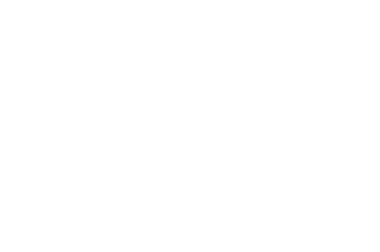

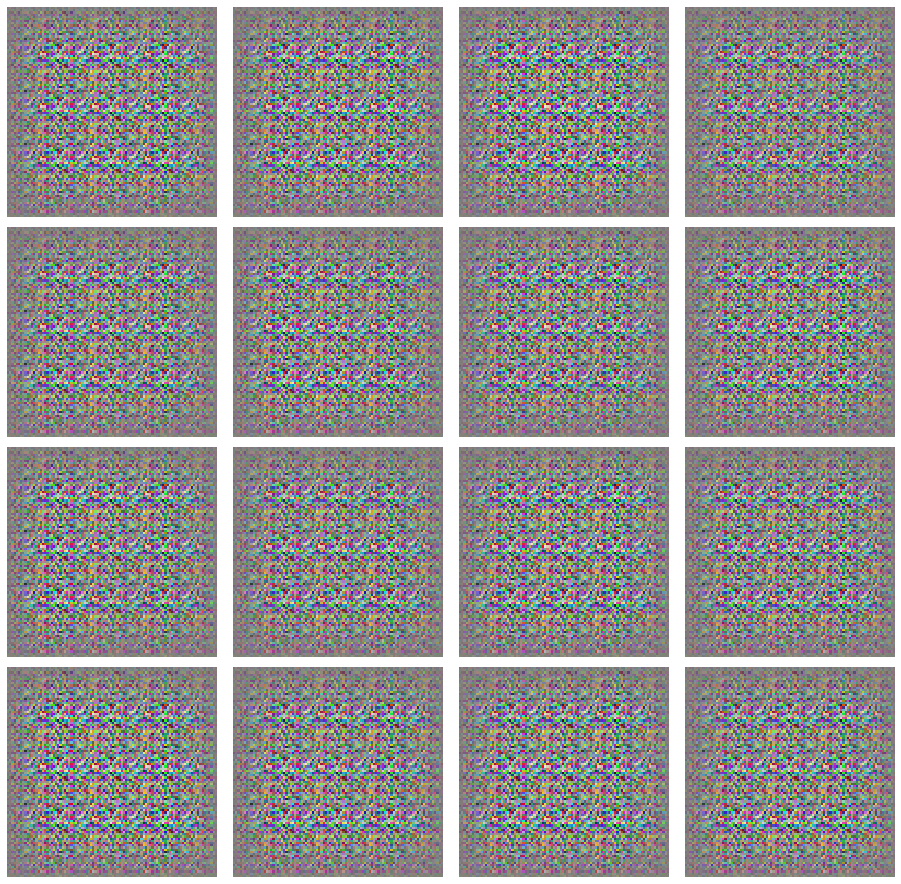

the times of 201 batch trainning :G loss is 0.1558048129081726, D loss is 0.22706899046897888
the times of 202 batch trainning :G loss is 0.15575680136680603, D loss is 0.2294069528579712
the times of 203 batch trainning :G loss is 0.15525700151920319, D loss is 0.22688674926757812
the times of 204 batch trainning :G loss is 0.15571743249893188, D loss is 0.22885775566101074
the times of 205 batch trainning :G loss is 0.15531828999519348, D loss is 0.22978326678276062
the times of 206 batch trainning :G loss is 0.15555697679519653, D loss is 0.22815798223018646
the times of 207 batch trainning :G loss is 0.15541575849056244, D loss is 0.23194551467895508
the times of 208 batch trainning :G loss is 0.15531669557094574, D loss is 0.23238630592823029
the times of 209 batch trainning :G loss is 0.15572428703308105, D loss is 0.2297111451625824
the times of 210 batch trainning :G loss is 0.15564069151878357, D loss is 0.23456165194511414
the times of 211 batch trainning :G loss is 0.1554724

the times of 287 batch trainning :G loss is 0.1550133228302002, D loss is 0.22890523076057434
the times of 288 batch trainning :G loss is 0.1548340618610382, D loss is 0.2305353879928589
the times of 289 batch trainning :G loss is 0.15494486689567566, D loss is 0.22482983767986298
the times of 290 batch trainning :G loss is 0.1552063226699829, D loss is 0.22662097215652466
the times of 291 batch trainning :G loss is 0.15499752759933472, D loss is 0.22938084602355957
the times of 292 batch trainning :G loss is 0.15485849976539612, D loss is 0.2276661992073059
the times of 293 batch trainning :G loss is 0.1553007960319519, D loss is 0.23057261109352112
the times of 294 batch trainning :G loss is 0.15519775450229645, D loss is 0.23026825487613678
the times of 295 batch trainning :G loss is 0.1552528738975525, D loss is 0.22777634859085083
the times of 296 batch trainning :G loss is 0.15491187572479248, D loss is 0.22715650498867035
the times of 297 batch trainning :G loss is 0.15521897375

the times of 373 batch trainning :G loss is 0.15502701699733734, D loss is 0.22538292407989502
the times of 374 batch trainning :G loss is 0.15490540862083435, D loss is 0.2244476079940796
the times of 375 batch trainning :G loss is 0.15480363368988037, D loss is 0.22730618715286255
the times of 376 batch trainning :G loss is 0.15493497252464294, D loss is 0.23003670573234558
the times of 377 batch trainning :G loss is 0.1546831578016281, D loss is 0.22822728753089905
the times of 378 batch trainning :G loss is 0.15477706491947174, D loss is 0.22409987449645996
the times of 379 batch trainning :G loss is 0.1547194868326187, D loss is 0.2301255613565445
the times of 380 batch trainning :G loss is 0.15461650490760803, D loss is 0.23172643780708313
the times of 381 batch trainning :G loss is 0.15485772490501404, D loss is 0.22880204021930695
the times of 382 batch trainning :G loss is 0.15466785430908203, D loss is 0.22569678723812103
the times of 383 batch trainning :G loss is 0.15475492

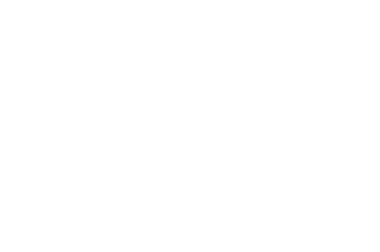

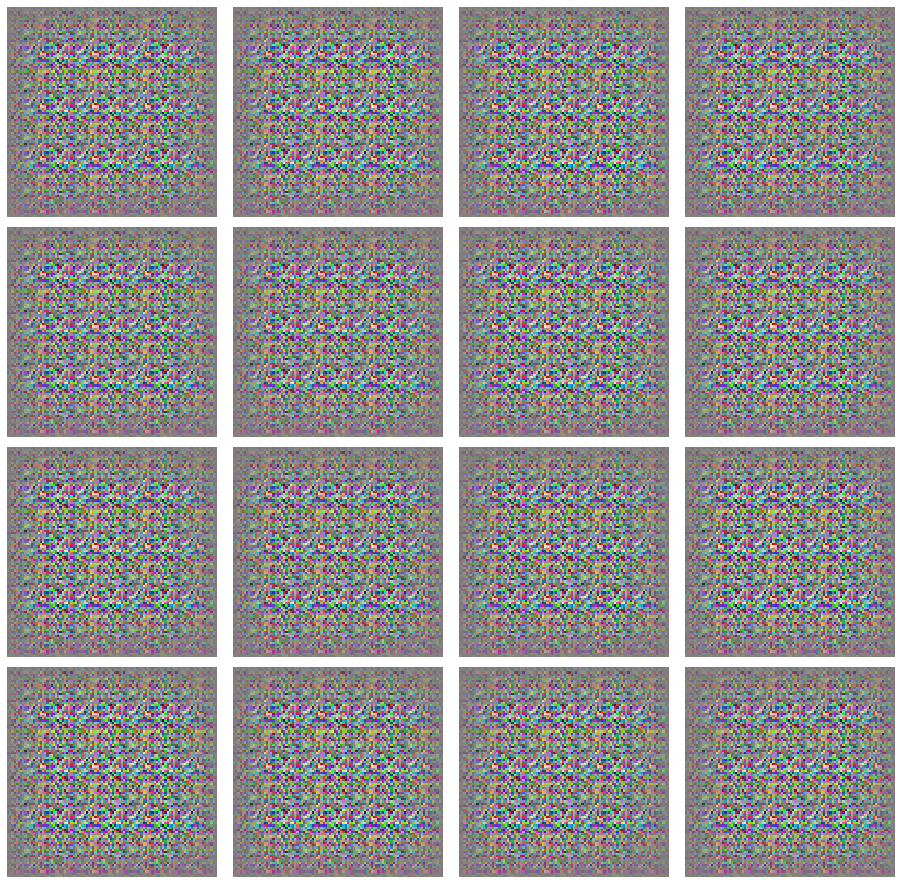

the times of 401 batch trainning :G loss is 0.15501472353935242, D loss is 0.22501397132873535
the times of 402 batch trainning :G loss is 0.15499621629714966, D loss is 0.22963686287403107
the times of 403 batch trainning :G loss is 0.15504765510559082, D loss is 0.22877924144268036
the times of 404 batch trainning :G loss is 0.15504750609397888, D loss is 0.22808045148849487
the times of 405 batch trainning :G loss is 0.1548830270767212, D loss is 0.2260042130947113
the times of 406 batch trainning :G loss is 0.15494447946548462, D loss is 0.22880198061466217
the times of 407 batch trainning :G loss is 0.15498051047325134, D loss is 0.23123271763324738
the times of 408 batch trainning :G loss is 0.15501397848129272, D loss is 0.23155049979686737
the times of 409 batch trainning :G loss is 0.15490487217903137, D loss is 0.22870832681655884
the times of 410 batch trainning :G loss is 0.15491244196891785, D loss is 0.2282344400882721
the times of 411 batch trainning :G loss is 0.1550276

the times of 487 batch trainning :G loss is 0.15473854541778564, D loss is 0.227032870054245
the times of 488 batch trainning :G loss is 0.1546057164669037, D loss is 0.22924460470676422
the times of 489 batch trainning :G loss is 0.15480510890483856, D loss is 0.22660042345523834
the times of 490 batch trainning :G loss is 0.15471181273460388, D loss is 0.22935886681079865
the times of 491 batch trainning :G loss is 0.15486213564872742, D loss is 0.22599734365940094
the times of 492 batch trainning :G loss is 0.1547614336013794, D loss is 0.22522656619548798
the times of 493 batch trainning :G loss is 0.1546521931886673, D loss is 0.2241845726966858
the times of 494 batch trainning :G loss is 0.15475870668888092, D loss is 0.2313128411769867
the times of 495 batch trainning :G loss is 0.15489113330841064, D loss is 0.23169496655464172
the times of 496 batch trainning :G loss is 0.15461856126785278, D loss is 0.22995075583457947
the times of 497 batch trainning :G loss is 0.15467143058

the times of 573 batch trainning :G loss is 0.15481019020080566, D loss is 0.23003257811069489
the times of 574 batch trainning :G loss is 0.15480437874794006, D loss is 0.2242686152458191
the times of 575 batch trainning :G loss is 0.1546650379896164, D loss is 0.22650381922721863
the times of 576 batch trainning :G loss is 0.1548081785440445, D loss is 0.22802472114562988
the times of 577 batch trainning :G loss is 0.15494784712791443, D loss is 0.2270386815071106
the times of 578 batch trainning :G loss is 0.1548151969909668, D loss is 0.22849136590957642
the times of 579 batch trainning :G loss is 0.15477240085601807, D loss is 0.22814589738845825
the times of 580 batch trainning :G loss is 0.15483814477920532, D loss is 0.23112386465072632
the times of 581 batch trainning :G loss is 0.15476277470588684, D loss is 0.22699308395385742
the times of 582 batch trainning :G loss is 0.15490221977233887, D loss is 0.22770710289478302
the times of 583 batch trainning :G loss is 0.154765293

the times of 659 batch trainning :G loss is 0.15482717752456665, D loss is 0.2302490472793579
the times of 660 batch trainning :G loss is 0.15489831566810608, D loss is 0.2294534593820572
the times of 661 batch trainning :G loss is 0.15469293296337128, D loss is 0.22844277322292328
the times of 662 batch trainning :G loss is 0.15482427179813385, D loss is 0.22689712047576904
the times of 663 batch trainning :G loss is 0.15481796860694885, D loss is 0.22419872879981995
the times of 664 batch trainning :G loss is 0.15485608577728271, D loss is 0.22548457980155945
the times of 665 batch trainning :G loss is 0.15481910109519958, D loss is 0.2299249917268753
the times of 666 batch trainning :G loss is 0.15491046011447906, D loss is 0.2260998785495758
the times of 667 batch trainning :G loss is 0.15473632514476776, D loss is 0.23045529425144196
the times of 668 batch trainning :G loss is 0.1548955738544464, D loss is 0.23036862909793854
the times of 669 batch trainning :G loss is 0.154772102

the times of 745 batch trainning :G loss is 0.15477879345417023, D loss is 0.22916868329048157
the times of 746 batch trainning :G loss is 0.15490153431892395, D loss is 0.229840949177742
the times of 747 batch trainning :G loss is 0.15471148490905762, D loss is 0.22661125659942627
the times of 748 batch trainning :G loss is 0.15494456887245178, D loss is 0.22558116912841797
the times of 749 batch trainning :G loss is 0.1549881249666214, D loss is 0.22761647403240204
the times of 750 batch trainning :G loss is 0.15498262643814087, D loss is 0.22758781909942627
the times of 751 batch trainning :G loss is 0.15485379099845886, D loss is 0.23068253695964813
the times of 752 batch trainning :G loss is 0.15499421954154968, D loss is 0.22919854521751404
the times of 753 batch trainning :G loss is 0.15497857332229614, D loss is 0.22342011332511902
the times of 754 batch trainning :G loss is 0.15499122440814972, D loss is 0.2258320450782776
the times of 755 batch trainning :G loss is 0.15493282

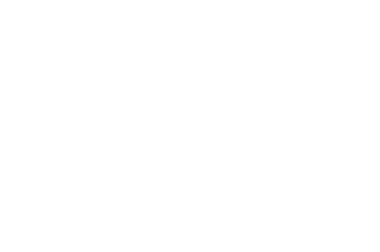

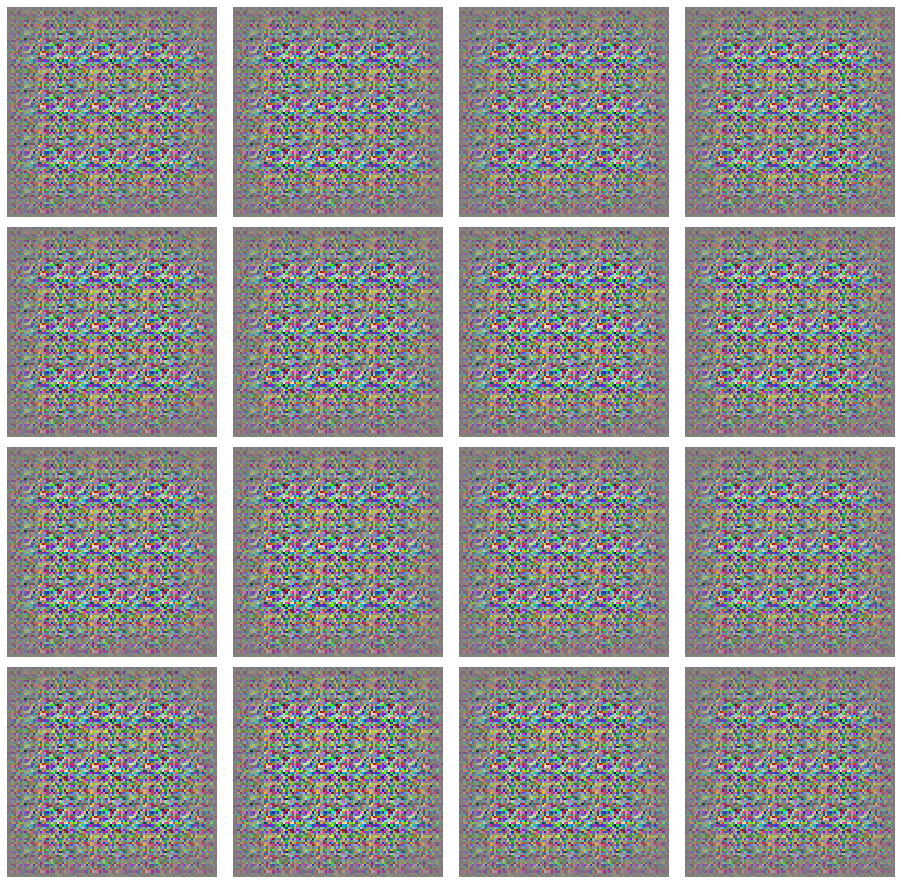

the times of 801 batch trainning :G loss is 0.15611416101455688, D loss is 0.2330695539712906
the times of 802 batch trainning :G loss is 0.15480470657348633, D loss is 0.22729793190956116
the times of 803 batch trainning :G loss is 0.1549796760082245, D loss is 0.22707541286945343
the times of 804 batch trainning :G loss is 0.15488645434379578, D loss is 0.22723358869552612
the times of 805 batch trainning :G loss is 0.15496163070201874, D loss is 0.22857244312763214
the times of 806 batch trainning :G loss is 0.1547904908657074, D loss is 0.22769029438495636
the times of 807 batch trainning :G loss is 0.1548711061477661, D loss is 0.22649289667606354
the times of 808 batch trainning :G loss is 0.15475380420684814, D loss is 0.2274097502231598
the times of 809 batch trainning :G loss is 0.15479497611522675, D loss is 0.22681467235088348
the times of 810 batch trainning :G loss is 0.1547226905822754, D loss is 0.22711752355098724
the times of 811 batch trainning :G loss is 0.1547238826

the times of 887 batch trainning :G loss is 0.15480151772499084, D loss is 0.22573909163475037
the times of 888 batch trainning :G loss is 0.15485984086990356, D loss is 0.229169100522995
the times of 889 batch trainning :G loss is 0.15476830303668976, D loss is 0.22707849740982056
the times of 890 batch trainning :G loss is 0.15476873517036438, D loss is 0.22465750575065613
the times of 891 batch trainning :G loss is 0.15482911467552185, D loss is 0.22664740681648254
the times of 892 batch trainning :G loss is 0.15484899282455444, D loss is 0.22645649313926697
the times of 893 batch trainning :G loss is 0.15466688573360443, D loss is 0.22398212552070618
the times of 894 batch trainning :G loss is 0.15485063195228577, D loss is 0.22700968384742737
the times of 895 batch trainning :G loss is 0.15477809309959412, D loss is 0.22820767760276794
the times of 896 batch trainning :G loss is 0.15455345809459686, D loss is 0.2256624400615692
the times of 897 batch trainning :G loss is 0.1548802

the times of 973 batch trainning :G loss is 0.15471084415912628, D loss is 0.2265993058681488
the times of 974 batch trainning :G loss is 0.15483686327934265, D loss is 0.22737646102905273
the times of 975 batch trainning :G loss is 0.15500222146511078, D loss is 0.2253001481294632
the times of 976 batch trainning :G loss is 0.1548527181148529, D loss is 0.2288583517074585
the times of 977 batch trainning :G loss is 0.15477022528648376, D loss is 0.22636383771896362
the times of 978 batch trainning :G loss is 0.15495634078979492, D loss is 0.22743257880210876
the times of 979 batch trainning :G loss is 0.1548006683588028, D loss is 0.22551730275154114
the times of 980 batch trainning :G loss is 0.1548587828874588, D loss is 0.22658400237560272
the times of 981 batch trainning :G loss is 0.15486343204975128, D loss is 0.22653469443321228
the times of 982 batch trainning :G loss is 0.1548488289117813, D loss is 0.22858478128910065
the times of 983 batch trainning :G loss is 0.15484198927

the times of 1059 batch trainning :G loss is 0.15494787693023682, D loss is 0.22564923763275146
the times of 1060 batch trainning :G loss is 0.15488851070404053, D loss is 0.2246885597705841
the times of 1061 batch trainning :G loss is 0.15499454736709595, D loss is 0.22982332110404968
the times of 1062 batch trainning :G loss is 0.15493172407150269, D loss is 0.22883419692516327
the times of 1063 batch trainning :G loss is 0.15493541955947876, D loss is 0.22479209303855896
the times of 1064 batch trainning :G loss is 0.15502913296222687, D loss is 0.22754427790641785
the times of 1065 batch trainning :G loss is 0.15478046238422394, D loss is 0.2282445877790451
the times of 1066 batch trainning :G loss is 0.15481968224048615, D loss is 0.22614210844039917
the times of 1067 batch trainning :G loss is 0.1549793779850006, D loss is 0.2238028347492218
the times of 1068 batch trainning :G loss is 0.15479356050491333, D loss is 0.2272287905216217
the times of 1069 batch trainning :G loss is 

the times of 1144 batch trainning :G loss is 0.15482261776924133, D loss is 0.22864249348640442
the times of 1145 batch trainning :G loss is 0.15466076135635376, D loss is 0.2255912721157074
the times of 1146 batch trainning :G loss is 0.15481719374656677, D loss is 0.22689561545848846
the times of 1147 batch trainning :G loss is 0.1547926664352417, D loss is 0.2269897758960724
the times of 1148 batch trainning :G loss is 0.15481826663017273, D loss is 0.22397537529468536
the times of 1149 batch trainning :G loss is 0.15471579134464264, D loss is 0.2279675304889679
the times of 1150 batch trainning :G loss is 0.1548895239830017, D loss is 0.226212739944458
the times of 1151 batch trainning :G loss is 0.1548282951116562, D loss is 0.2233119159936905
the times of 1152 batch trainning :G loss is 0.1549423485994339, D loss is 0.22768494486808777
the times of 1153 batch trainning :G loss is 0.15483659505844116, D loss is 0.2287033647298813
the times of 1154 batch trainning :G loss is 0.1548

the times of 1230 batch trainning :G loss is 0.1550409346818924, D loss is 0.22906780242919922
the times of 1231 batch trainning :G loss is 0.15490582585334778, D loss is 0.22494515776634216
the times of 1232 batch trainning :G loss is 0.15491528809070587, D loss is 0.22478348016738892
the times of 1233 batch trainning :G loss is 0.1550278663635254, D loss is 0.2281031310558319
the times of 1234 batch trainning :G loss is 0.15493810176849365, D loss is 0.22674965858459473
the times of 1235 batch trainning :G loss is 0.1549098938703537, D loss is 0.22737109661102295
the times of 1236 batch trainning :G loss is 0.15501514077186584, D loss is 0.22409522533416748
the times of 1237 batch trainning :G loss is 0.15497559309005737, D loss is 0.22734202444553375
the times of 1238 batch trainning :G loss is 0.15488135814666748, D loss is 0.22802072763442993
the times of 1239 batch trainning :G loss is 0.15500453114509583, D loss is 0.22545187175273895
the times of 1240 batch trainning :G loss is

the times of 1315 batch trainning :G loss is 0.15487216413021088, D loss is 0.2268148958683014
the times of 1316 batch trainning :G loss is 0.15487833321094513, D loss is 0.22475555539131165
the times of 1317 batch trainning :G loss is 0.15489372611045837, D loss is 0.22604158520698547
the times of 1318 batch trainning :G loss is 0.15491367876529694, D loss is 0.22476011514663696
the times of 1319 batch trainning :G loss is 0.15486431121826172, D loss is 0.22729109227657318
the times of 1320 batch trainning :G loss is 0.15495340526103973, D loss is 0.2275148332118988
the times of 1321 batch trainning :G loss is 0.15486997365951538, D loss is 0.2259025126695633
the times of 1322 batch trainning :G loss is 0.1548895239830017, D loss is 0.22560866177082062
the times of 1323 batch trainning :G loss is 0.154975026845932, D loss is 0.22680051624774933
the times of 1324 batch trainning :G loss is 0.15487995743751526, D loss is 0.2219773828983307
the times of 1325 batch trainning :G loss is 0.

the times of 1400 batch trainning :G loss is 0.1548299938440323, D loss is 0.23039616644382477
the times of 1401 batch trainning :G loss is 0.1549692451953888, D loss is 0.22759220004081726
the times of 1402 batch trainning :G loss is 0.15481805801391602, D loss is 0.22408244013786316
the times of 1403 batch trainning :G loss is 0.15495359897613525, D loss is 0.22657138109207153
the times of 1404 batch trainning :G loss is 0.15480661392211914, D loss is 0.22686371207237244
the times of 1405 batch trainning :G loss is 0.15486447513103485, D loss is 0.22802449762821198
the times of 1406 batch trainning :G loss is 0.15499445796012878, D loss is 0.22542732954025269
the times of 1407 batch trainning :G loss is 0.15491479635238647, D loss is 0.22727620601654053
the times of 1408 batch trainning :G loss is 0.15482619404792786, D loss is 0.22570595145225525
the times of 1409 batch trainning :G loss is 0.15477757155895233, D loss is 0.2298864871263504
the times of 1410 batch trainning :G loss i

the times of 1485 batch trainning :G loss is 0.1549355685710907, D loss is 0.21987971663475037
the times of 1486 batch trainning :G loss is 0.1548984944820404, D loss is 0.22694920003414154
the times of 1487 batch trainning :G loss is 0.1549379527568817, D loss is 0.22669020295143127
the times of 1488 batch trainning :G loss is 0.15486755967140198, D loss is 0.2294417917728424
the times of 1489 batch trainning :G loss is 0.15499934554100037, D loss is 0.22787724435329437
the times of 1490 batch trainning :G loss is 0.15510214865207672, D loss is 0.22562752664089203
the times of 1491 batch trainning :G loss is 0.155084028840065, D loss is 0.22750824689865112
the times of 1492 batch trainning :G loss is 0.15493789315223694, D loss is 0.22506210207939148
the times of 1493 batch trainning :G loss is 0.1549447923898697, D loss is 0.22647038102149963
the times of 1494 batch trainning :G loss is 0.15498192608356476, D loss is 0.22607111930847168
the times of 1495 batch trainning :G loss is 0.

the times of 1570 batch trainning :G loss is 0.15508927404880524, D loss is 0.2278420627117157
the times of 1571 batch trainning :G loss is 0.1549929976463318, D loss is 0.224623441696167
the times of 1572 batch trainning :G loss is 0.15488849580287933, D loss is 0.22746816277503967
the times of 1573 batch trainning :G loss is 0.15490955114364624, D loss is 0.2256992608308792
the times of 1574 batch trainning :G loss is 0.15496087074279785, D loss is 0.22445785999298096
the times of 1575 batch trainning :G loss is 0.15503272414207458, D loss is 0.22737008333206177
the times of 1576 batch trainning :G loss is 0.154832124710083, D loss is 0.22606852650642395
the times of 1577 batch trainning :G loss is 0.15506994724273682, D loss is 0.22965627908706665
the times of 1578 batch trainning :G loss is 0.15486928820610046, D loss is 0.2270500808954239
the times of 1579 batch trainning :G loss is 0.15499266982078552, D loss is 0.22945886850357056
the times of 1580 batch trainning :G loss is 0.1

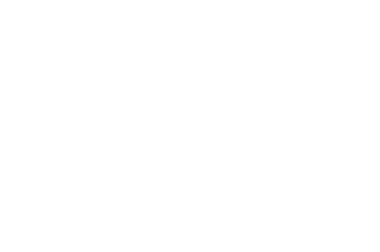

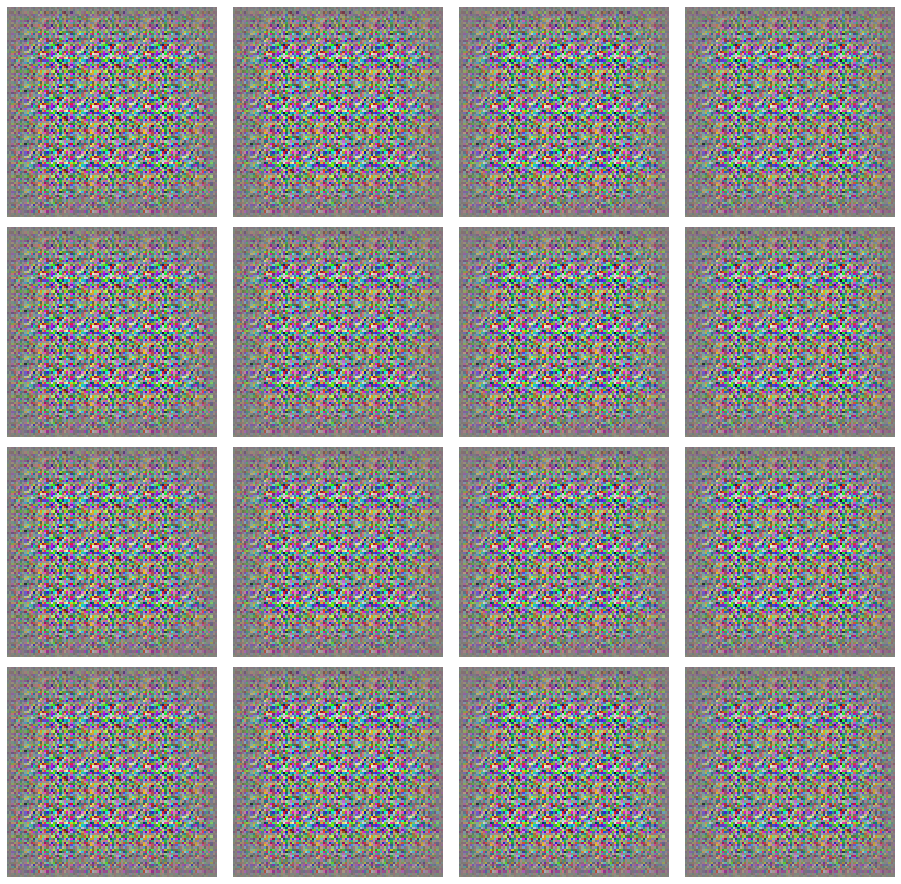

the times of 1601 batch trainning :G loss is 0.1550041288137436, D loss is 0.2273072600364685
the times of 1602 batch trainning :G loss is 0.1550239771604538, D loss is 0.22904938459396362
the times of 1603 batch trainning :G loss is 0.15589624643325806, D loss is 0.22881582379341125
the times of 1604 batch trainning :G loss is 0.15513619780540466, D loss is 0.22757588326931
the times of 1605 batch trainning :G loss is 0.15506204962730408, D loss is 0.2228190004825592
the times of 1606 batch trainning :G loss is 0.15507358312606812, D loss is 0.22731643915176392
the times of 1607 batch trainning :G loss is 0.15507104992866516, D loss is 0.22827917337417603
the times of 1608 batch trainning :G loss is 0.15521809458732605, D loss is 0.22448565065860748
the times of 1609 batch trainning :G loss is 0.1551472246646881, D loss is 0.2290872037410736
the times of 1610 batch trainning :G loss is 0.15518319606781006, D loss is 0.22449234127998352
the times of 1611 batch trainning :G loss is 0.15

the times of 1686 batch trainning :G loss is 0.15498918294906616, D loss is 0.22784380614757538
the times of 1687 batch trainning :G loss is 0.1551879197359085, D loss is 0.22541280090808868
the times of 1688 batch trainning :G loss is 0.15508726239204407, D loss is 0.22601358592510223
the times of 1689 batch trainning :G loss is 0.1551123410463333, D loss is 0.22822484374046326
the times of 1690 batch trainning :G loss is 0.15517553687095642, D loss is 0.2249138057231903
the times of 1691 batch trainning :G loss is 0.15514391660690308, D loss is 0.2259458601474762
the times of 1692 batch trainning :G loss is 0.15514570474624634, D loss is 0.2253759205341339
the times of 1693 batch trainning :G loss is 0.155076265335083, D loss is 0.22563183307647705
the times of 1694 batch trainning :G loss is 0.15502282977104187, D loss is 0.2267819494009018
the times of 1695 batch trainning :G loss is 0.15504127740859985, D loss is 0.2248336672782898
the times of 1696 batch trainning :G loss is 0.15

the times of 1771 batch trainning :G loss is 0.1551036238670349, D loss is 0.22396895289421082
the times of 1772 batch trainning :G loss is 0.15513697266578674, D loss is 0.2243409901857376
the times of 1773 batch trainning :G loss is 0.15510019659996033, D loss is 0.2272188812494278
the times of 1774 batch trainning :G loss is 0.15515947341918945, D loss is 0.22508607804775238
the times of 1775 batch trainning :G loss is 0.155074805021286, D loss is 0.22424502670764923
the times of 1776 batch trainning :G loss is 0.1549977958202362, D loss is 0.2269970029592514
the times of 1777 batch trainning :G loss is 0.15509933233261108, D loss is 0.2299228459596634
the times of 1778 batch trainning :G loss is 0.155161052942276, D loss is 0.22510117292404175
the times of 1779 batch trainning :G loss is 0.15507429838180542, D loss is 0.22885486483573914
the times of 1780 batch trainning :G loss is 0.15516990423202515, D loss is 0.22631718218326569
the times of 1781 batch trainning :G loss is 0.155

the times of 1856 batch trainning :G loss is 0.15517574548721313, D loss is 0.22529178857803345
the times of 1857 batch trainning :G loss is 0.1552087366580963, D loss is 0.22426095604896545
the times of 1858 batch trainning :G loss is 0.1550663560628891, D loss is 0.22543185949325562
the times of 1859 batch trainning :G loss is 0.1552823781967163, D loss is 0.225937619805336
the times of 1860 batch trainning :G loss is 0.1551443636417389, D loss is 0.2241131067276001
the times of 1861 batch trainning :G loss is 0.155176043510437, D loss is 0.22831667959690094
the times of 1862 batch trainning :G loss is 0.15502819418907166, D loss is 0.2289181798696518
the times of 1863 batch trainning :G loss is 0.1551024615764618, D loss is 0.2252994179725647
the times of 1864 batch trainning :G loss is 0.15504667162895203, D loss is 0.22726558148860931
the times of 1865 batch trainning :G loss is 0.1551770269870758, D loss is 0.22738243639469147
the times of 1866 batch trainning :G loss is 0.155195

the times of 1942 batch trainning :G loss is 0.15503495931625366, D loss is 0.22860699892044067
the times of 1943 batch trainning :G loss is 0.15519750118255615, D loss is 0.22916415333747864
the times of 1944 batch trainning :G loss is 0.15500500798225403, D loss is 0.22681783139705658
the times of 1945 batch trainning :G loss is 0.1551515758037567, D loss is 0.2261929214000702
the times of 1946 batch trainning :G loss is 0.1551956832408905, D loss is 0.22529000043869019
the times of 1947 batch trainning :G loss is 0.15504541993141174, D loss is 0.22580108046531677
the times of 1948 batch trainning :G loss is 0.1550411880016327, D loss is 0.2304079681634903
the times of 1949 batch trainning :G loss is 0.1550801396369934, D loss is 0.22887933254241943
the times of 1950 batch trainning :G loss is 0.1550929993391037, D loss is 0.2280488759279251
the times of 1951 batch trainning :G loss is 0.1551124006509781, D loss is 0.22722359001636505
the times of 1952 batch trainning :G loss is 0.15

the times of 2027 batch trainning :G loss is 0.15515758097171783, D loss is 0.22289398312568665
the times of 2028 batch trainning :G loss is 0.15498681366443634, D loss is 0.22774982452392578
the times of 2029 batch trainning :G loss is 0.15511366724967957, D loss is 0.2225833237171173
the times of 2030 batch trainning :G loss is 0.15501955151557922, D loss is 0.22443905472755432
the times of 2031 batch trainning :G loss is 0.15506641566753387, D loss is 0.22512038052082062
the times of 2032 batch trainning :G loss is 0.1551494151353836, D loss is 0.2309570461511612
the times of 2033 batch trainning :G loss is 0.15508049726486206, D loss is 0.22726137936115265
the times of 2034 batch trainning :G loss is 0.15516433119773865, D loss is 0.22490093111991882
the times of 2035 batch trainning :G loss is 0.15510624647140503, D loss is 0.22721290588378906
the times of 2036 batch trainning :G loss is 0.15511944890022278, D loss is 0.22431662678718567
the times of 2037 batch trainning :G loss i

the times of 2112 batch trainning :G loss is 0.15514054894447327, D loss is 0.22791028022766113
the times of 2113 batch trainning :G loss is 0.15508855879306793, D loss is 0.22666428983211517
the times of 2114 batch trainning :G loss is 0.15511474013328552, D loss is 0.2274167388677597
the times of 2115 batch trainning :G loss is 0.15506796538829803, D loss is 0.22547563910484314
the times of 2116 batch trainning :G loss is 0.1551908254623413, D loss is 0.22321781516075134
the times of 2117 batch trainning :G loss is 0.15514957904815674, D loss is 0.22616758942604065
the times of 2118 batch trainning :G loss is 0.1551474630832672, D loss is 0.22608785331249237
the times of 2119 batch trainning :G loss is 0.15519648790359497, D loss is 0.22662509977817535
the times of 2120 batch trainning :G loss is 0.15515188872814178, D loss is 0.2232651263475418
the times of 2121 batch trainning :G loss is 0.1551404595375061, D loss is 0.2278975397348404
the times of 2122 batch trainning :G loss is 0

the times of 2197 batch trainning :G loss is 0.15514066815376282, D loss is 0.2243310511112213
the times of 2198 batch trainning :G loss is 0.15511634945869446, D loss is 0.22438208758831024
the times of 2199 batch trainning :G loss is 0.15519194304943085, D loss is 0.2230311930179596
the times of 2200 batch trainning :G loss is 0.15531517565250397, D loss is 0.22504639625549316
the times of 2201 batch trainning :G loss is 0.15514421463012695, D loss is 0.22638100385665894
the times of 2202 batch trainning :G loss is 0.15515753626823425, D loss is 0.22408674657344818
the times of 2203 batch trainning :G loss is 0.1551731526851654, D loss is 0.22621120512485504
the times of 2204 batch trainning :G loss is 0.15511418879032135, D loss is 0.22705596685409546
the times of 2205 batch trainning :G loss is 0.15516701340675354, D loss is 0.22774752974510193
the times of 2206 batch trainning :G loss is 0.1551567018032074, D loss is 0.22727882862091064
the times of 2207 batch trainning :G loss is

the times of 2282 batch trainning :G loss is 0.15507730841636658, D loss is 0.22510936856269836
the times of 2283 batch trainning :G loss is 0.1551682949066162, D loss is 0.22737157344818115
the times of 2284 batch trainning :G loss is 0.15517812967300415, D loss is 0.22867022454738617
the times of 2285 batch trainning :G loss is 0.15510453283786774, D loss is 0.2264394462108612
the times of 2286 batch trainning :G loss is 0.1550804227590561, D loss is 0.22493267059326172
the times of 2287 batch trainning :G loss is 0.15513858199119568, D loss is 0.22730854153633118
the times of 2288 batch trainning :G loss is 0.1550692319869995, D loss is 0.2241312563419342
the times of 2289 batch trainning :G loss is 0.1550993174314499, D loss is 0.2283664047718048
the times of 2290 batch trainning :G loss is 0.1551370918750763, D loss is 0.22913268208503723
the times of 2291 batch trainning :G loss is 0.15506727993488312, D loss is 0.22584229707717896
the times of 2292 batch trainning :G loss is 0.1

the times of 2367 batch trainning :G loss is 0.15525652468204498, D loss is 0.22748692333698273
the times of 2368 batch trainning :G loss is 0.15522423386573792, D loss is 0.22628572583198547
the times of 2369 batch trainning :G loss is 0.1552232950925827, D loss is 0.22565177083015442
the times of 2370 batch trainning :G loss is 0.15511180460453033, D loss is 0.22593086957931519
the times of 2371 batch trainning :G loss is 0.15517589449882507, D loss is 0.22641007602214813
the times of 2372 batch trainning :G loss is 0.15516063570976257, D loss is 0.22426684200763702
the times of 2373 batch trainning :G loss is 0.15507826209068298, D loss is 0.22665730118751526
the times of 2374 batch trainning :G loss is 0.15506106615066528, D loss is 0.2247971147298813
the times of 2375 batch trainning :G loss is 0.15517987310886383, D loss is 0.22337478399276733
the times of 2376 batch trainning :G loss is 0.15511426329612732, D loss is 0.22423195838928223
the times of 2377 batch trainning :G loss 

In [ ]:
cnt = 0
for epoch in range(model_param.epochs):
    for imgs in dload:
        batch = imgs.shape[0]
        real_img = Variable(imgs).cuda()
        sample_nois = Variable((torch.rand(batch, model_param.noise, 1 ,1) - 0.5) / 0.5).cuda()
        fake_img = G(sample_nois)
        
        ## train D
        real_score = D(real_img)
        fake_score = D(fake_img)
        D_loss = Discrim_Loss(real_score, fake_score)
        
        D_optim.zero_grad()
        D_loss.backward()
        D_optim.step()
        
        ## train G
        fake_img = G(sample_nois)
        fake_score = D(fake_img)
        G_loss = Gen_Loss(fake_score)
        
        G_optim.zero_grad()
        G_loss.backward()
        G_optim.step()
        # update
        print("the times of {} batch trainning :G loss is {}, D loss is {}".format(cnt, G_loss.data, D_loss.data))
        if cnt % model_param.interval == 0:
            model_param.interval *= model_param.deta_inv
            plt.axis("off")
#             plt.imshow(fake_img[0][0].detach().numpy()
            fake_img = fake_img[:16].detach().cpu() 
            show_images(fake_img*0.5+0.5) # [-1,1] -> [0,1]
#             img_ = img_* 20 + 80
#             print(img_.shape)
            plt.show()
        cnt+=1
#         print("the {} times batch trainning :G loss is {}, D loss is {}".format(cnt, G_loss.data, D_loss.data))
torch.save(netD.state_dict(), './netd_%s.pth' )
torch.save(netG.state_dict(), './netg_%s.pth' ) 